<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#导包" data-toc-modified-id="导包-1">导包</a></span></li><li><span><a href="#数据预处理" data-toc-modified-id="数据预处理-2">数据预处理</a></span></li><li><span><a href="#数据读入" data-toc-modified-id="数据读入-3">数据读入</a></span></li><li><span><a href="#分词预览" data-toc-modified-id="分词预览-4">分词预览</a></span></li><li><span><a href="#统计高频词" data-toc-modified-id="统计高频词-5">统计高频词</a></span><ul class="toc-item"><li><span><a href="#代码实现" data-toc-modified-id="代码实现-5.1">代码实现</a></span></li><li><span><a href="#查看词表" data-toc-modified-id="查看词表-5.2">查看词表</a></span></li></ul></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-6">TF-IDF</a></span><ul class="toc-item"><li><span><a href="#代码实现" data-toc-modified-id="代码实现-6.1">代码实现</a></span></li><li><span><a href="#查看词表" data-toc-modified-id="查看词表-6.2">查看词表</a></span></li></ul></li><li><span><a href="#词表筛选" data-toc-modified-id="词表筛选-7">词表筛选</a></span><ul class="toc-item"><li><span><a href="#阈值选取" data-toc-modified-id="阈值选取-7.1">阈值选取</a></span></li><li><span><a href="#进行筛选" data-toc-modified-id="进行筛选-7.2">进行筛选</a></span></li></ul></li><li><span><a href="#保存分词" data-toc-modified-id="保存分词-8">保存分词</a></span></li><li><span><a href="#手动筛选" data-toc-modified-id="手动筛选-9">手动筛选</a></span></li></ul></div>

## 导包

In [1]:
import json
import re
import jieba
import pandas as pd

# tf-idf
import math
import functools
import numpy as np

## 数据预处理

In [2]:
intent_index = {
    '建议运动': '0',
    '治疗方案': '0',
    '药物': '0',
    '检查项目': '0',
    '无': '0',
    '症状': '0',
    '疾病': '0',
    '建议食物': '0',
    '治疗价格': '0',
    '病因': '0',
    '简介': '0',
    '诊断': '0',
    '预防措施': '0',
    '科室': '0',
    '禁忌食物': '0',
    '医疗机构': '0',
    '康复疗法': '0',
    '用药指南': '0',
    '食物': '0',
    '禁忌运动': '0'
}

# 疾病词典地址
disease_path = 'D:/PycharmProjects/job/job/diseases.json'

# 症状词典地址
symptoms_path = 'D:/PycharmProjects/job/job/symptoms.json'

In [3]:
# 加载字典 json读入内存转dict后再转成list
def json2list(path):
    with open(path, encoding='utf-8') as file:
        data = json.load(file)
    return [d['name'] for d in data]

In [ ]:
# 疾病词典
diseases = json2list(disease_path)

# 保存
with open('user_dict.txt',"w", encoding='utf-8') as f:
    for d in diseases:
        f.writelines(d)
        f.writelines("\n")

In [ ]:
# 症状词典        
symptoms = json2list(symptoms_path)

# 保存
with open('user_dict.txt',"a+", encoding='utf-8') as f:
    for s in symptoms:
        f.writelines(s)
        f.writelines("\n")

In [ ]:
# 常用语词典
oral_list = [
    '怎么了',
    '怎么办',
    '干啥',
    '咋回事',
    '吃啥',
    '吃什么',
    '什么样子',
    '怎么回事',
    '是什么',
    '为什么',
    '做什么',
    '何为',
    '好治吗',
    '能治好吗',
    '什么意思',
    '康复运动',
    '康复锻炼',
    '康复的快',
    '什么是',
    '好的快',
    '什么是',
    '不能',
    '不应该',
    '什么药好',
    '不该',
    '什么项目',
    '什么意思',
    '是什么'
]

# 保存
with open('user_dict.txt',"a+", encoding='utf-8') as f:
    for o in oral_list:
        f.writelines(o)
        f.writelines("\n")

In [4]:
def clean_query(sentence):
    """
    去除特殊字符和空格,用于分词
    """
    punctuation = '@#$%^&*()_+=-`，：*《》<>|（）、｛｝【】“”‘’。.!！，,;:?？"\''
    return re.sub(
        r'[{}]+'.format(punctuation), '',
        sentence.replace(' ', '')
    )

In [ ]:
def clean_query2(sentence):
    """
    去除特殊字符和空格,用于筛选数据
    去掉奇异字符,保留原数据
    """
    punctuation = '@#$%^&*()_+=-`*《》<>|（）｛｝【】‘’.!！,;:"\''
    return re.sub(
        r'[{}]+'.format(punctuation), '',
        sentence.replace(' ', '')
    )

In [5]:
def text_from_feature(feature, single_data, multi_data=None):
    """
    从数据集中选择unknown列为feature值的querys
    将其拼接为一段文本
    并进行特殊字符串处理
    """
    # 处理单意图文件
    temp = single_data[single_data['unknown']==feature]
    querys = temp['question']
    text = ''
    for q in querys:
        text += clean_query(q)
        
    # 处理多意图文件
    if multi_data is not None:
        for index, line in multi_data.iterrows():
            unknown_list = line['unknown'].split(',')
            if feature in unknown_list:
                text += clean_query(str(line['question']))
            
    return text

In [6]:
def get_stop_words(path):
    """从路径path中加载停止词词典"""
    with open(path, encoding='utf-8') as file:
        return [line.strip() for line in file]

# 停止词词典 
stop_words = get_stop_words('./data/stop_words.utf8')

## 数据读入

In [7]:
single_path = 'D:/GitHub/bert_finetune-master/data/single/single.tsv'
multi_path = 'D:/GitHub/bert_finetune-master/data/multi/multi.tsv'
single_data = pd.read_csv(single_path, sep='\t')
multi_data = pd.read_csv(multi_path, sep='\t')

## 分词预览

In [8]:
def split_result(text, intent=None, clean=True):
    """
    基于自定义词典对text进行分词,
    去掉停止词,
    打印分词结果
    clean指定是否需要将分词结果去掉疾病和症状字典,
    默认为True,去掉
    """
    # 读入词典
    dict_path = './user_dict.txt'
    jieba.load_userdict(dict_path)

    # 进行分词
    split_words = list(jieba.cut(text))
    split_words = [word for word in split_words if word not in stop_words]
    
    if clean:
        diseases = json2list(disease_path)
        symptoms = json2list(symptoms_path)
        diseases.extend(symptoms)
        split_words = [word for word in split_words if word not in diseases]
    # 打印结果
    if intent is not None:
        print(
            "split result of {}:{}".format(
                intent,
                '/'.join(split_words)
            )  
        )

    return split_words

In [ ]:
t = text_from_feature('简介', single_data, multi_data)
print(t)

In [ ]:
split_result(t, '简介')

## 统计高频词

### 代码实现

In [48]:
# 统计高频词

def get_TF(words, topK=10):
    """从分词后的结果列表words中提取出出现频率最高的前topK个词"""
    tf_dic = {}
    for word in words:
        tf_dic[word] = tf_dic.get(word, 0) + 1
    # dic[1] 按出现次数排序 reverse = True 降序 
    # sorted结果为一个list,返回前topK个元素
    return sorted(tf_dic.items(), key=lambda dic: dic[1], reverse=True)[:topK]

In [49]:
def word_frequency(text, intent, topk):
    """
    输出前topk的单词
    """
    
    # 进行分词
    split_words = split_result(text)
    
    # 输出结果
    print(
        '{} top{} word:{}'.format(
            intent, 
            topk,
            str(get_TF(split_words,topk))
        )
    )

### 查看词表

In [50]:
for intent in list(intent_index.keys()):
    # 得到所有intent的querys
    text = text_from_feature(str(intent), single_data, multi_data)
    word_frequency(text, str(intent), 10)

建议运动 top10 word:[('做什么', 346), ('运动', 345), ('恢复', 151), ('有助于', 101), ('康复运动', 101), ('康复', 98), ('治疗', 65), ('适合', 55), ('康复锻炼', 55), ('帮助', 53)]
治疗方案 top10 word:[('治疗', 167), ('方法', 48), ('怎么办', 23), ('怎样', 20), ('如何', 19), ('症状', 19), ('是什么', 17), ('现在', 14), ('检查', 12), ('这种', 12)]
药物 top10 word:[('药', 73), ('吃什么', 52), ('治疗', 52), ('吃', 28), ('什么药好', 17), ('最好', 14), ('药物', 14), ('治', 12), ('症状', 11), ('检查', 10)]
检查项目 top10 word:[('检查', 80), ('需要', 52), ('做什么', 52), ('确定', 25), ('确诊', 25), ('项目', 8), ('缺乏', 5), ('怎样', 5), ('症状', 5), ('维生素', 3)]
无 top10 word:[('严重', 12), ('治疗', 11), ('中医', 9), ('效果', 8), ('程度', 8), ('手术', 5), ('多久', 5), ('恢复', 4), ('检查', 4), ('不治会', 3)]
症状 top10 word:[('症状', 72), ('是什么', 12), ('表现', 9), ('临床', 8), ('吃什么', 8), ('早期', 6), ('治疗', 6), ('检查', 6), ('什么是', 5), ('引起', 5)]
疾病 top10 word:[('症状', 11), ('是不是', 11), ('治疗', 5), ('表现', 4), ('吃饭', 4), ('还是', 4), ('医生', 4), ('说', 4), ('是否', 4), ('老是', 4)]
建议食物 top10 word:[('吃什么', 50), ('饮食', 28), ('治疗', 19), ('食物'

## TF-IDF

### 代码实现

In [9]:
# idf值统计方法

def train_idf(doc_list):
    idf_dic = {}
    # 总文档数
    tt_count = len(doc_list)

    # 每个词出现的文档数
    for doc in doc_list:
        for word in set(doc):
            idf_dic[word] = idf_dic.get(word, 0.0) + 1.0

    # 按公式转换为idf值，分母加1进行平滑处理
    for k, v in idf_dic.items():
        idf_dic[k] = math.log(tt_count / (1.0 + v))

    # 对于没有在字典中的词，默认其仅在一个文档出现，得到默认idf值
    default_idf = math.log(tt_count / (1.0))
    return idf_dic, default_idf

In [10]:
#  排序函数，用于topK关键词的按值排序
def cmp(e1, e2):
    import numpy as np
    res = np.sign(e1[1] - e2[1])
    if res != 0:
        return res
    else:
        a = e1[0] + e2[0]
        b = e2[0] + e1[0]
        if a > b:
            return 1
        elif a == b:
            return 0
        else:
            return -1

In [11]:
# TF-IDF类
class TfIdf(object):
    # 四个参数分别是：训练好的idf字典，默认idf值，处理后的待提取文本，关键词数量
    def __init__(self, idf_dic, default_idf, word_list, keyword_num):
        self.word_list = word_list
        self.idf_dic, self.default_idf = idf_dic, default_idf
        self.tf_dic = self.get_tf_dic()
        self.keyword_num = keyword_num

    # 统计tf值
    def get_tf_dic(self):
        tf_dic = {}
        for word in self.word_list:
            tf_dic[word] = tf_dic.get(word, 0.0) + 1.0

        tt_count = len(self.word_list)
        for k, v in tf_dic.items():
            tf_dic[k] = float(v) / tt_count

        return tf_dic

    # 按公式计算tf-idf
    def get_tfidf(self):
        tfidf_dic = {}
        for word in self.word_list:
            idf = self.idf_dic.get(word, self.default_idf)
            tf = self.tf_dic.get(word, 0)

            tfidf = tf * idf
            tfidf_dic[word] = tfidf   
        return tfidf_dic
    
    # 返回关键词
    def get_frequecy(self):
        tfidf_dic = self.get_tf_dic()
        tfidf_dic.items()
        # 根据tf-idf排序，去排名前keyword_num的词作为关键词
        for k, v in sorted(tfidf_dic.items(), key=functools.cmp_to_key(cmp), reverse=True)[:self.keyword_num]:
            print(k + "/ ", end='')
        print()    

In [12]:
# 文档集合准备
# 一个text是一篇文档
# 共20种文档，组成文档集
docs = []
for intent in list(intent_index.keys()):
    # 得到所有intent的querys
    text = text_from_feature(str(intent), single_data, multi_data)
    
    # 将元组(意图, text分词结果)存入docs文档集
    docs.append(
        (intent, split_result(text))
    )

# 只包含文档的列表
text_list = [doc[1] for doc in docs]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.926 seconds.
Prefix dict has been built successfully.


In [13]:
# 在文档集中根据意图返回文档
def get_doc_by_intent(intent, docs):
    for doc in docs:
        if str(doc[0]) == intent:
            return doc[1]

In [14]:
# 获得所有单词的idf值
idf_dic , default_idf = train_idf(text_list)
list(idf_dic.items())[:5]

[('肺', 1.0498221244986776),
 ('轻度', 1.2039728043259361),
 ('些', 1.0498221244986776),
 ('食物', 0.6931471805599453),
 ('半小时', 1.0498221244986776)]

In [15]:
# 根据intent获取tf_idf字典
def tfidf_dic_by_intent(intent,docs):
    doc = get_doc_by_intent(intent,docs)
    tfidf = TfIdf(idf_dic, default_idf, doc, 10)
    return tfidf.get_tfidf()

### 查看词表

In [51]:
for intent_text in docs:
    tfidf = TfIdf(idf_dic, default_idf, intent_text[1], 10)
    print('*********{}*********'.format(intent_text[0]))
    tfidf.get_frequecy()
    print()

*********建议运动*********
做什么/ 运动/ 恢复/ 有助于/ 康复运动/ 康复/ 治疗/ 适合/ 康复锻炼/ 来/ 

*********治疗方案*********
治疗/ 方法/ 怎么办/ 怎样/ 症状/ 如何/ 是什么/ 现在/ 这种/ 检查/ 

*********药物*********
药/ 治疗/ 吃什么/ 吃/ 什么药好/ 药物/ 最好/ 治/ 症状/ 检查/ 

*********检查项目*********
检查/ 需要/ 做什么/ 确诊/ 确定/ 项目/ 缺乏/ 症状/ 怎样/ 维生素/ 

*********无*********
严重/ 治疗/ 中医/ 程度/ 效果/ 手术/ 多久/ 检查/ 恢复/ 怎么样/ 

*********症状*********
症状/ 是什么/ 表现/ 吃什么/ 临床/ 治疗/ 检查/ 早期/ 引起/ 什么是/ 

*********疾病*********
症状/ 是不是/ 治疗/ 还是/ 说/ 表现/ 老是/ 疼/ 是否/ 时/ 

*********建议食物*********
吃什么/ 饮食/ 治疗/ 食物/ 什么是/ 吃/ 患者/ 食疗/ 怎样/ 需要/ 

*********治疗价格*********
多少/ 钱/ 治疗/ 手术/ 钱治/ 检查/ 费用/ 食管癌/ 怎样/ 原因/ 

*********病因*********
原因/ 治疗/ 是什么/ 引起/ 病因/ 方法/ 症状/ 怎么回事/ 颤抖/ 造成/ 

*********简介*********
什么是/ 治疗/ 吃什么/ 食物/ 药/ 危害/ 是什么/ 如何/ 症状/ 检查/ 

*********诊断*********
检查/ 诊断/ 判断/ 是不是/ 症状/ 需要/ 确诊/ 怎样/ 多少/ 确定/ 

*********预防措施*********
预防/ 治疗/ 怎样/ 如何/ 症状/ 检查/ 怎么样/ 食管癌/ 防治/ 生病/ 

*********科室*********
检查/ 治疗/ 科室/ 情况/ 怎么回事/ 做什么/ 颤抖/ 预约/ 那科/ 这种/ 

*********禁忌食物*********
饮食/ 治疗/ 吃什么/ 吃/ 患者/ 食物/ 怎样/ 需要/ 如何/ 药/ 

*********医疗机构*******

## 词表筛选

In [ ]:
# 建议运动
sport_key = ['康复运动', '做什么', '有助于', '运动', '康复锻炼']

# 治疗方案
plan_key = ['治疗', '方法', '怎么办', '这种']

# 药物
med_key = ['药', '什么药好', '治疗', '吃什么']

# 检查项目
check_key = ['检查'. '做什么', '项目', '确诊']

# 症状
sys_key = ['症状', '是什么', '早期', '表现', '临床']

# 疾病
dis_key = ['症状', '是否', '表现', '是不是']

# 建议食物
food_key = ['食物', '吃什么', '饮食', '食疗']

# 治疗价格
pri_key = ['费用', '多少钱', '手术', '多少']

# 病因
rea_key = ['引起', '原因', '病因', '怎么回事', '造成']

# 简介
intro_key = ['什么是', '是什么', '如何', '危害']

# 诊断
if_key = ['诊断', '是不是', '判断', '确定', '确诊']

# 预防措施
act_key = ['怎样', '预防', '如何', '防治']

# 科室
dep_key = ['科室', '预约', '那科', '检查']

# 康复疗法 无法进行手动筛选
hea_key = ['康复', '计划', '怎样才能', '需要']

# 用药指南
guide_key = ['美托', '硝酸甘油', '洛尔', '治疗', '吃什么']

# 食物
foo_key = ['豆浆', '食物', '喝', '吃', '最好']

# 禁忌运动手动进行筛选

In [16]:
def norm_min_max(weight_i, weight_list):
    weights = np.array(weight_list)
    mi = weights.min()
    ma = weights.max()
    weights_norm = []
    return (weight_i - mi)/(ma-mi)

def softmax(weight_i, weight_list):
    sum_exp = 0
    for i in weight_list:
        sum_exp += math.exp(i)
    return math.exp(weight_i)/sum_exp

In [17]:
def tfidf2softmax(tfidf_dic, keywords):
    # 根据tf_idf值取得softmax值
    # keywords是定义好的关键词list
    # 字典(keywords:tfidf)
    word_weights = {}
    for word in keywords:
        word_weights[word] = tfidf_dic.get(word)
    
    weights = [i for i in word_weights.values()]
    
    # {keywords: tfidf} -> {keywords: softmax(tfidf)}
    for key in list(word_weights.keys()):
        value = word_weights[key]
        word_weights[key] = softmax(value, weights)
    return word_weights

In [18]:
def count_querys(m, intent, word_weights, data):
    # 记录选中的数据条数
    # m为阈值
    counts = 0
    for index, line in data.iterrows():
        # 分词结果已经存在文件中的split列
        word_list = line['split'].split(',')
        num = 0
        for i in word_weights.keys():
            if i in word_list:
                num += word_weights.get(i)
        if num > m:
            counts = counts + 1
    return counts

In [ ]:
def select_questions(m, intent, word_weights, data):
    # data为分词后的数据
    # m为阈值
    counts = 0
    querys = []
    ids = []
    for index, line in data.iterrows():
        word_list = line['split'].split(',')
        num = 0
        for i in word_weights.keys():
            if i in word_list:
                num += word_weights.get(i)
        if num > m:
            counts = counts + 1
#             print(line['content'])
            ids.append(line['question_id'])
            querys.append(
                clean_query2(line['content'])
            )
    dataset = pd.DataFrame(
        data = {
            'question_id':ids,
            'content':querys
        }
    )
    dataset.to_csv('{}_{}.csv'.format(intent, counts), index=False)
    return counts

### 阈值选取

In [19]:
# 导入待筛选的数据
question_path = 'D:/PycharmProjects/NLP_Action/after_split.csv'
data = pd.read_csv(question_path)
data = data.dropna(axis=0)

In [21]:
import matplotlib.pyplot as plt
import matplotlib

In [27]:
def show_threshold(intent, x, y, maxy):
    matplotlib.rc('font', family='SimHei')
    plt.rcParams['axes.unicode_minus'] = False
    plt.ylim(0, maxy)
    plt.plot(x, y)
    plt.title(intent, loc='center')
    plt.xlabel('threshold')
    plt.ylabel('querys')
    plt.tight_layout()
    plt.margins(0, 0)
    plt.savefig('{}.png'.format(intent), dpi=300, pad_inches=0, bbox_inches='tight')
    
    plt.show()

In [23]:
sport_intent = '建议运动'
sport_key = ['康复运动', '做什么', '有助于', '运动', '康复锻炼']
sport_dic = tfidf_dic_by_intent(sport_intent, docs)
sport_weights = tfidf2softmax(sport_dic, sport_key)
sport_x = np.arange(0.15, 0.26, 0.01)
sport_y = []
for hold in sport_x:
    sport_y.append(
        count_querys(hold, sport_intent, sport_weights, data)
    )

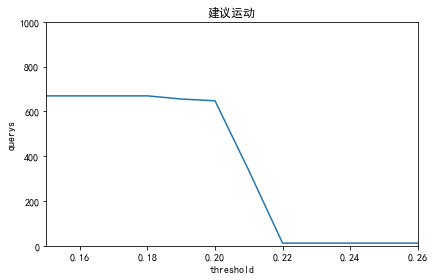

In [28]:
show_threshold(sport_intent, sport_x, sport_y, 1000)

In [30]:
plan_intent = '治疗方案'
plan_key = ['治疗', '方法', '怎么办', '这种']
plan_dic = tfidf_dic_by_intent(plan_intent, docs)
plan_weights = tfidf2softmax(plan_dic, plan_key)
plan_x = np.arange(0.2, 0.8, 0.1)
plan_y = []
for hold in plan_x:
    plan_y.append(
        count_querys(hold, plan_intent, plan_weights, data)
    )

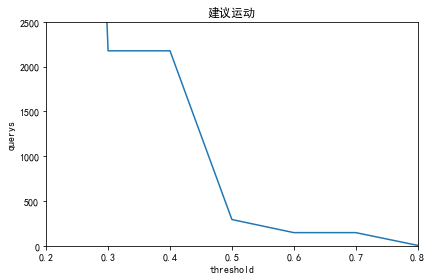

In [35]:
show_threshold(sport_intent, plan_x, plan_y, 2500)

In [36]:
med_intent = '药物'
med_key = ['药', '什么药好', '治疗', '吃什么']
med_dic = tfidf_dic_by_intent(med_intent, docs)
med_weights = tfidf2softmax(med_dic, med_key)
med_x = np.arange(0.55, 0.7, 0.05)
med_y = []
for hold in med_x:
    med_y.append(
        count_querys(hold, med_intent, med_weights, data)
    )

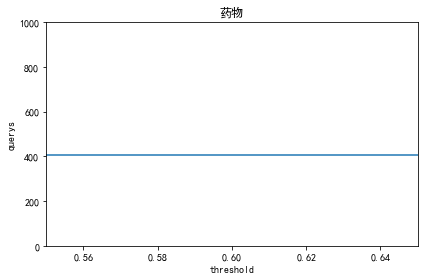

In [38]:
show_threshold(med_intent, med_x, med_y, 1000)

In [41]:
food_intent = '建议食物'
food_key = ['食物', '吃什么', '饮食', '食疗']
food_dic = tfidf_dic_by_intent(food_intent, docs)
food_weights = tfidf2softmax(food_dic, food_key)
food_x = np.arange(0.2, 0.3, 0.01)
food_y = []
for hold in food_x:
    food_y.append(
        count_querys(hold, food_intent, food_weights, data)
    )

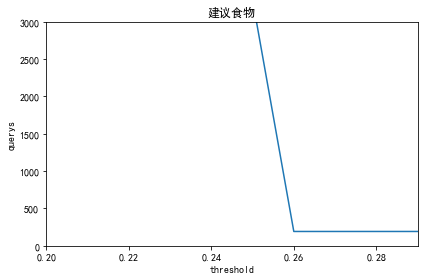

In [44]:
show_threshold(food_intent, food_x, food_y, 3000)

### 进行筛选

In [ ]:
my_intent = '建议运动'
sport_key = ['康复运动', '做什么', '有助于', '运动', '康复锻炼']
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, sport_key)
num = select_questions(0.21, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 治疗方案
plan_key = ['治疗', '方法', '怎么办', '这种']
my_intent = '治疗方案'

tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, plan_key)
num = select_questions(0.5, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 药物
med_key = ['药', '什么药好', '治疗', '吃什么']

my_intent = '药物'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, med_key)
num = select_questions(0.6, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 检查项目
check_key = ['检查', '做什么', '项目', '确诊']

my_intent = '检查项目'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, check_key)
num = select_questions(0.45, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 症状
sys_key = ['症状', '是什么', '早期', '表现', '临床']

my_intent = '症状'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, sys_key)
num = select_questions(0.403, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 疾病
dis_key = ['症状', '是否', '表现', '是不是']

my_intent = '疾病'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, dis_key)
num = select_questions(0.49975, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 建议食物
food_key = ['食物', '吃什么', '饮食', '食疗']
# 0.25断崖 - 0.26
my_intent = '建议食物'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, food_key)
num = select_questions(0.26, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 治疗价格
pri_key = ['费用', '多少钱', '手术', '多少']

my_intent = '治疗价格'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, pri_key)
num = select_questions(0.26, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 病因
rea_key = ['引起', '原因', '病因', '怎么回事', '造成']

my_intent = '病因'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, rea_key)
num = select_questions(0.3985, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 简介
intro_key = ['什么是', '是什么', '如何', '危害']

my_intent = '简介'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, intro_key)
num = select_questions(0.3985, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 诊断
if_key = ['诊断', '是不是', '判断', '确定', '确诊']

my_intent = '诊断'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, if_key)
num = select_questions(0.25, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 预防措施
act_key = ['怎样', '预防', '如何', '防治']

my_intent = '预防措施'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, act_key)
num = select_questions(0.25, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 科室
dep_key = ['科室', '预约', '那科', '检查']

my_intent = '科室'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, dep_key)
num = select_questions(0.25, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 康复疗法
hea_key = ['康复', '计划', '怎样才能', '需要']

my_intent = '康复疗法'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, hea_key)
num = select_questions(0.25, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 用药指南
guide_key = ['美托', '硝酸甘油', '洛尔', '治疗']

my_intent = '用药指南'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, guide_key)
num = select_questions(0.179, my_intent, word_weights, data)
print('共计{}条'.format(num))

In [ ]:
# 食物
foo_key = ['豆浆', '食物', '喝', '吃', '最好']

my_intent = '食物'
tfidf_dic = tfidf_dic_by_intent(my_intent, docs)
word_weights = tfidf2softmax(tfidf_dic, foo_key)
num = select_questions(0.3, my_intent, word_weights, data)
print('共计{}条'.format(num))

## 保存分词

In [ ]:
def select_questions(m, word_weights, data):
    # data为分词后的数据
    # m为阈值
    for index, line in data.iterrows():
        word_list = line['split'].split(',')
        num = 0
        counts = 0
        for i in word_weights.keys():
            if i in word_list:
                num += word_weights.get(i)
        if num > m:
            counts += 1
            print(line['question_id'], line['content'])
    return counts

In [ ]:
# 导入数据
question_path = 'D:/PycharmProjects/NLP_Action/data/query6w.csv'
data = pd.read_csv(question_path)

In [ ]:
# 对所有句子进行分词,存入文件
def split_all_sentence(data):
    split_sentences = []
    querys = []
    ids = []
    for index, line in data.iterrows():
        word_list = split_result(line['content'])
        print(word_list)
        split_sentences.append(','.join(word_list))    
        querys.append(line['content'])
        ids.append(line['question_id'])
    sys = pd.DataFrame(
        data={
            'question_id':ids,
            'content': querys,
            'split':split_sentences
        }
    )
    sys.to_csv('after_split.csv', index=False)

In [ ]:
split_all_sentence(data)

## 手动筛选

In [ ]:
# 建议运动
sport_key = ['康复运动', '做什么运动']

# 药物
med_key = ['用什么药']

# 检查项目
check_key = ['做什么检查']

# 症状
sys_key = ['是什么症状']

# 疾病
dis_key = ['是什么病']

# 建议食物
food_key = ['食疗', '吃什么好']

# 治疗价格
pri_key = ['费用', '多少钱']

# 病因
rea_key = ['怎么引起的', '什么原因']

# 简介
intro_key = ['是什么', '什么是', '危害']

# 预防措施
act_key = ['怎样预防', '如何防治']

# 科室
dep_key = ['挂什么科']

# 用药指南
guide_key = ['药怎么吃']

# 治疗方案
plan_key = ['怎么治疗', '怎样治疗']

# 禁忌食物
not_key = ['不宜吃', '不能吃']

# 手术
not_key = ['做手术吗', '做什么手术', '做手术']

# 并发症
not_key = ['并发症', '引发什么', '引发哪些', '会引发']

In [46]:
def select_querys(intent, key_list, data):
    # intent 意图名称
    # key_list关键词列表
    # data 原始数据集
    # 在data上筛出含有key_list中词的query,并存入文件
    querys = []
    ids = []
    intents = []
    for index, line in data.iterrows():
        for key in key_list:
            if key in line['content']:
                querys.append(line['content'])
                ids.append(line['question_id'])
    sys = pd.DataFrame(
        data={
            'question_id':ids,
            'content': querys,
        }
    )
    sys.to_csv('./intent/{}.csv'.format(intent), index=False)

In [ ]:
# 建议运动
sport_key = ['康复运动', '做什么运动']
intent_name = '建议运动'
select_querys(intent_name, sport_key, data)

In [ ]:
# 药物
med_key = ['用什么药']
intent_name = '药物'
select_querys(intent_name, med_key, data)

In [ ]:
# 检查项目
check_key = ['做什么检查']
intent_name = '检查项目'
select_querys(intent_name, check_key, data)

In [ ]:
# 症状
sys_key = ['是什么症状']

intent_name = '症状'
select_querys(intent_name, sys_key, data)

In [ ]:
# 疾病
dis_key = ['是什么病']
intent_name = '疾病'
select_querys(intent_name, dis_key, data)

In [ ]:
# 建议食物
food_key = ['食疗', '吃什么好']
intent_name = '建议食物'
select_querys(intent_name, food_key, data)

In [ ]:
# 治疗价格
pri_key = ['费用', '多少钱']

intent_name = '治疗价格'
select_querys(intent_name, pri_key, data)

In [ ]:
# 病因
rea_key = ['怎么引起的', '什么原因']
intent_name = '病因'
select_querys(intent_name, rea_key, data)

In [ ]:
# 导入数据
question_path = 'D:/PycharmProjects/NLP_Action/data/query6w.csv'
data = pd.read_csv(question_path)
drop_index = []
for index, line in data.iterrows():
    if '什么原因' in line['content']:
        drop_index.append(index)
data = data.drop(drop_index, axis=0)

In [ ]:
# 简介
intro_key = ['是什么', '什么是', '危害']

intent_name = '简介'
select_querys(intent_name, intro_key, data)

In [ ]:
# 预防措施
act_key = ['怎样预防', '如何防治']
intent_name = '预防措施'
select_querys(intent_name, act_key, data)

In [ ]:
# 科室
dep_key = ['挂什么科']
intent_name = '科室'
select_querys(intent_name, dep_key, data)

In [ ]:
# 用药指南
guide_key = ['药怎么吃']
intent_name = '用药指南'
select_querys(intent_name, guide_key, data)

In [ ]:
# 治疗方案
plan_key = ['怎么治疗', '怎样治疗']
intent_name = '治疗方案'
select_querys(intent_name, plan_key, data)

In [ ]:
# 禁忌食物
not_key = ['不宜吃', '不能吃']
intent_name = '禁忌食物'
select_querys(intent_name, not_key, data)

In [53]:
# 手术
not_key = ['做手术吗', '做什么手术', '做手术']
intent_name = '手术'
select_querys(intent_name, not_key, data)

In [54]:
# 并发症
not_key = ['并发症', '引发什么', '引发哪些', '会引发']
intent_name = '并发症'
select_querys(intent_name, not_key, data)